# Metrics during GRACE era

In this notebook, we compare our TWS reconstruction to the GRACE, our target.

In [1]:
import string

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from cmcrameri import cm
from dask.diagnostics import ProgressBar
from matplotlib import ticker
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [4]:
our_store = (
    ROOT_DIR / "models/predictions/ensemble-mixed/ensemble-mixed_era_best-mae.zarr"
)
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
our = xr.open_zarr(our_store).twsa.rename("twsa_our")


Specify variables of interest and their descriptive names:

In [5]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, our])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


In [6]:
target_name = "twsa_csr"
our_name = "twsa_our"


## Error and correlation world maps

In [7]:
ds_grid = ds_all[[target_name, our_name]]
# Only evaluate GRACE time
ds_grid = ds_grid.sel(time=slice("2002", "2023")).compute()
# Remove missing time steps - remove missing time steps in GRACE for all vars
ds_grid = ds_grid.where(ds_grid.dr.time_notnull(), drop=True)
print(len(ds_grid.time))
# Calculate basin averages
ds_basin: xr.Dataset = (
    # Select variables and time frame of interest
    ds_grid.chunk(time=10, lat=-1, lon=-1)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)


212
[########################################] | 100% Completed | 14.28 s


In [8]:
# RMSE
our_rmse_grid = metrics.rmse(
    ds_grid[target_name], ds_grid[our_name], dim="time", skipna=True
)
our_rmse_basin = metrics.rmse(
    ds_basin[target_name], ds_basin[our_name], dim="time", skipna=True
)

# NSE
our_nse_grid = metrics.nse(
    ds_grid[target_name], ds_grid[our_name], dim="time", skipna=True
)
our_nse_basin = metrics.nse(
    ds_basin[target_name], ds_basin[our_name], dim="time", skipna=True
)


In [9]:
rmse_kwargs = dict(
    cbar_kwargs=dict(
        location="right", aspect=15, shrink=0.93, pad=0.03, label="RMSE (mm)"
    ),
    cmap=cm.batlow,
    coastlines=True,
    gridlines=True,
    coastlines_kwargs=dict(rasterized=True),
    rasterized=True,
)
nse_kwargs = dict(
    cbar_kwargs=dict(location="right", aspect=15, shrink=0.93, pad=0.03, label="NSE"),
    cmap=cm.bamako_r,
    coastlines=True,
    gridlines=True,
    coastlines_kwargs=dict(rasterized=True),
    rasterized=True,
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.5,
    facecolor="None",
    zorder=3.0,
    rasterized=True,
)
title_kwargs = dict(fontsize=16, weight="bold")


In [10]:
# GeoDataFrame containing basin shapes and areas
gdf_basin_shapes = basins(top=72)

# Series of basin areas, for scatter plotting
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]

# DataArray of basin areas, for weighting
da_basin_areas = xr.DataArray.from_series(s_basin_areas)

In [11]:
print(f"{our_rmse_grid.min() = :.2f}")
print(f"{our_rmse_grid.max() = :.2f}\n")

print(f"{our_nse_grid.min() = :.2f}")
print(f"{our_nse_grid.max() = :.2f}\n")

print(f"{our_rmse_basin.min() = :.2f}")
print(f"{our_rmse_basin.max() = :.2f}\n")

print(f"{our_nse_basin.min() = :.2f}")
print(f"{our_nse_basin.max() = :.2f}\n")


our_rmse_grid.min() = 6.74
our_rmse_grid.max() = 4230.21

our_nse_grid.min() = -84.02
our_nse_grid.max() = 0.99

our_rmse_basin.min() = 5.94
our_rmse_basin.max() = 107.00

our_nse_basin.min() = 0.71
our_nse_basin.max() = 0.99



In [12]:
print(f"{our_rmse_grid.dr.weight_lat().mean() = :.2f}")
print(f"{our_rmse_grid.dr.weight_lat().quantile(0.9) = :.2f}\n")

print(f"{our_nse_grid.dr.weight_lat().mean() = :.2f}")
print(f"{our_nse_grid.dr.weight_lat().quantile(0.9) = :.2f}\n")

print(f"{our_rmse_basin.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_rmse_basin.weighted(da_basin_areas).quantile(0.9) = :.2f}\n")

print(f"{our_nse_basin.weighted(da_basin_areas).mean() = :.2f}")
print(f"{our_nse_basin.weighted(da_basin_areas).quantile(0.9) = :.2f}\n")


our_rmse_grid.dr.weight_lat().mean() = 38.72
our_rmse_grid.dr.weight_lat().quantile(0.9) = 52.71

our_nse_grid.dr.weight_lat().mean() = 0.78
our_nse_grid.dr.weight_lat().quantile(0.9) = 0.95

our_rmse_basin.weighted(da_basin_areas).mean() = 16.68
our_rmse_basin.weighted(da_basin_areas).quantile(0.9) = 25.93

our_nse_basin.weighted(da_basin_areas).mean() = 0.92
our_nse_basin.weighted(da_basin_areas).quantile(0.9) = 0.98



[Text(0.5, 1.0, 'Basin scale')]

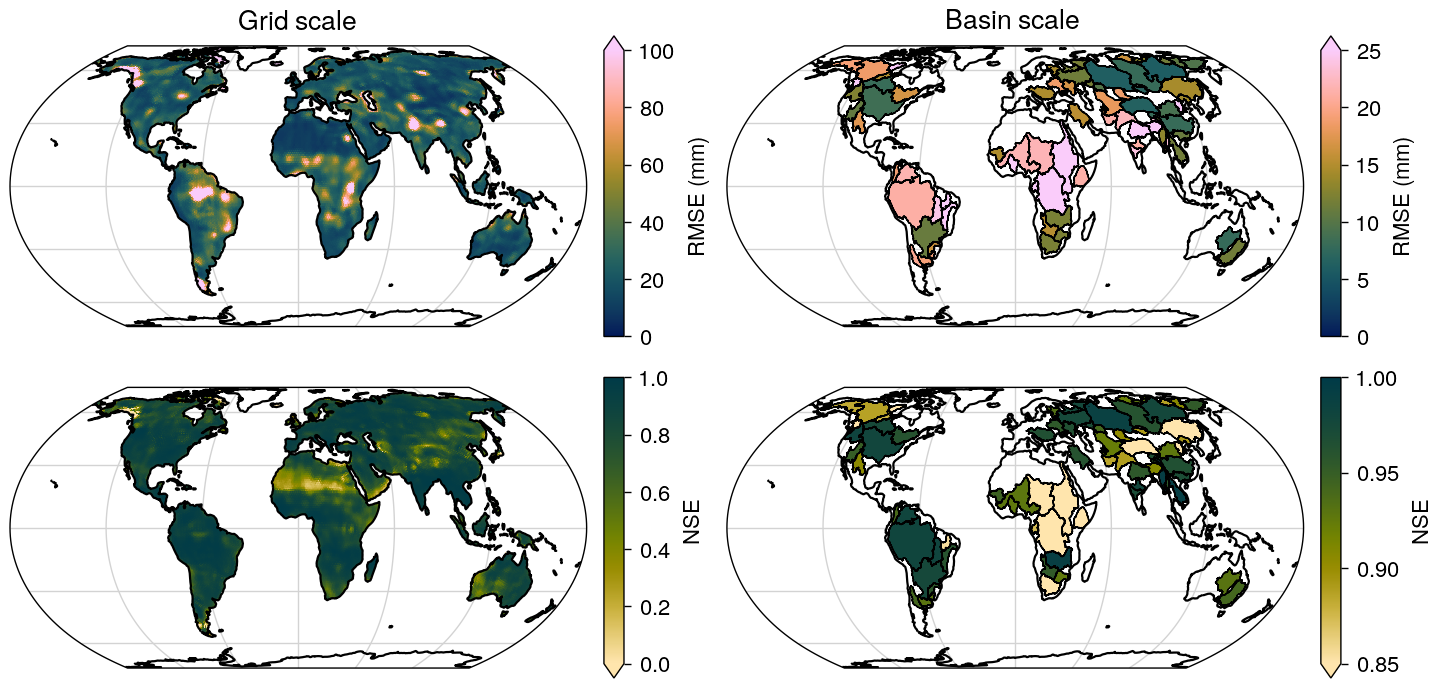

In [13]:
fig, axs = plt.subplots(
    2, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(7.2, 3.5)
)

# Grid scale plots
our_rmse_grid.dr.projplot(vmin=0, vmax=100, ax=axs[0][0], **rmse_kwargs)
our_nse_grid.dr.projplot(vmin=0.0, vmax=1.0, ax=axs[1][0], **nse_kwargs)

# Basin scale plots
our_rmse_basin.dr.projplot_basins(
    our_rmse_grid,
    vmin=0,
    vmax=25,
    ax=axs[0][1],
    **rmse_kwargs,
)
our_nse_basin.dr.projplot_basins(
    our_nse_grid,
    vmin=0.85,
    vmax=1.0,
    ax=axs[1][1],
    **nse_kwargs,
)

# Add basinlines
for ax in [axs[0][1], axs[1][1]]:
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Titles
axs[0][0].set(title="Grid scale")
axs[0][1].set(title="Basin scale")

# fig.savefig(FIGURE_DIR / "grace_comp_map.pdf", backend="pgf")


## Scatter plots of signal components

### Perform linear trend / multi-seasonal decomposition

We use the following function to approximate the constant $a$, the linear trend $b$, and the annual and semi-annual sinusoidal curves:

$$
y(t) = a + b \, t + c \, \sin(2π  \, t) + d \, \cos(2π \, t) + e \, \sin(4π \, t) + f \cos(4π \, t) + r
$$

In [14]:
YEAR_NS = 365.25 * 24 * 60 * 60 * 1e9


def decomp_func(
    t: np.ndarray, a: float, b: float, c: float, d: float, e: float, f: float
) -> np.ndarray:
    # Convert t from nanosecons to years
    t = t / YEAR_NS

    linear = a + b * t
    annual = c * np.sin(2 * np.pi * t) + d * np.cos(2 * np.pi * t)
    semian = e * np.sin(4 * np.pi * t) + f * np.cos(4 * np.pi * t)

    return linear + annual + semian


In [15]:
# Apply decomposition
# Curvefit skips missing values per default
fit = ds_basin.to_dataarray("model").curvefit("time", decomp_func)
fit


<xarray.Dataset> Size: 49kB
Dimensions:                (region: 72, model: 2, param: 6, cov_i: 6, cov_j: 6)
Coordinates:
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
  * model                  (model) object 16B 'twsa_csr' 'twsa_our'
  * param                  (param) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
  * cov_i                  (cov_i) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
  * cov_j                  (cov_j) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Data variables:
    curvefit_coefficients  (model, region, param) float64 7kB -67.54 ... -7.209
    curvefit_covariance    (model, region, cov_i, cov_j) float64 41kB 487.9 ....

### Calculate slope and amplitudes

In [16]:
# Linear trend: mm / yr
da_lintrend = fit.curvefit_coefficients.sel(param="b")

da_lintrend.attrs = {"long_name": "Trend", "unit": "mm / yr"}


Calculate annual amplitude:

$$
A = \sqrt{c^2 + d^2}
$$

In [17]:
c = fit.curvefit_coefficients.sel(param="c")
d = fit.curvefit_coefficients.sel(param="d")
e = fit.curvefit_coefficients.sel(param="e")
f = fit.curvefit_coefficients.sel(param="f")

da_amp_annual = np.sqrt(c**2 + d**2)
da_amp_semian = np.sqrt(e**2 + f**2)

da_amp_annual.attrs = {"long_name": "Annual amplitude", "unit": "mm"}
da_amp_semian.attrs = {"long_name": "Semi-annual amplitude", "unit": "mm"}


In [18]:
# Place components in dictionaries for easier batch handling
da_comps = {
    "lintrend": da_lintrend,
    "amp_annual": da_amp_annual,
    "amp_semian": da_amp_semian,
}
df_comps = {}
pcc_scores = {}

for name, da in da_comps.items():
    # Convert DataArrays to DataFrames for plotting with Seaborn
    df = (
        da.to_pandas()
        .transpose()
        .reset_index()
        # Add basin size column (in Million km)
        .merge(s_basin_areas / 1e6, on="region")
        # Sort after area so large basins are printed lastly
        .sort_values("area")
    )
    df_comps[name] = df

    # Calculate PCC
    pcc_scores[name] = metrics.pearson_r(
        da.sel(model=target_name), da.sel(model=our_name), weights=da_basin_areas
    )


In [19]:
# Units
units = {
    "lintrend": "mm yr$^-1$",
    "amp_annual": "mm",
    "amp_semian": "mm",
}
# Verbose names
names_verbose = {
    "lintrend": "Linear\ntrend",
    "amp_annual": "Annual\namplitude",
    "amp_semian": "Semiannual\namplitude",
}


In [20]:
print(f"{da_lintrend.min() = :.2f}")
print(f"{da_lintrend.max() = :.2f}")

print(f"{da_amp_annual.min() = :.2f}")
print(f"{da_amp_annual.max() = :.2f}")

print(f"{da_amp_semian.min() = :.2f}")
print(f"{da_amp_semian.max() = :.2f}")


da_lintrend.min() = -19.21
da_lintrend.max() = 9.69
da_amp_annual.min() = 5.21
da_amp_annual.max() = 220.26
da_amp_semian.min() = 1.05
da_amp_semian.max() = 68.94


In [21]:
# Limits
lims = {
    "lintrend": (-20, 10),
    "amp_annual": (0, 250),
    "amp_semian": (0, 80),
}
# Major locators
locs = {
    "lintrend": ticker.MultipleLocator(10),
    "amp_annual": ticker.MultipleLocator(50),
    "amp_semian": ticker.MultipleLocator(20),
}

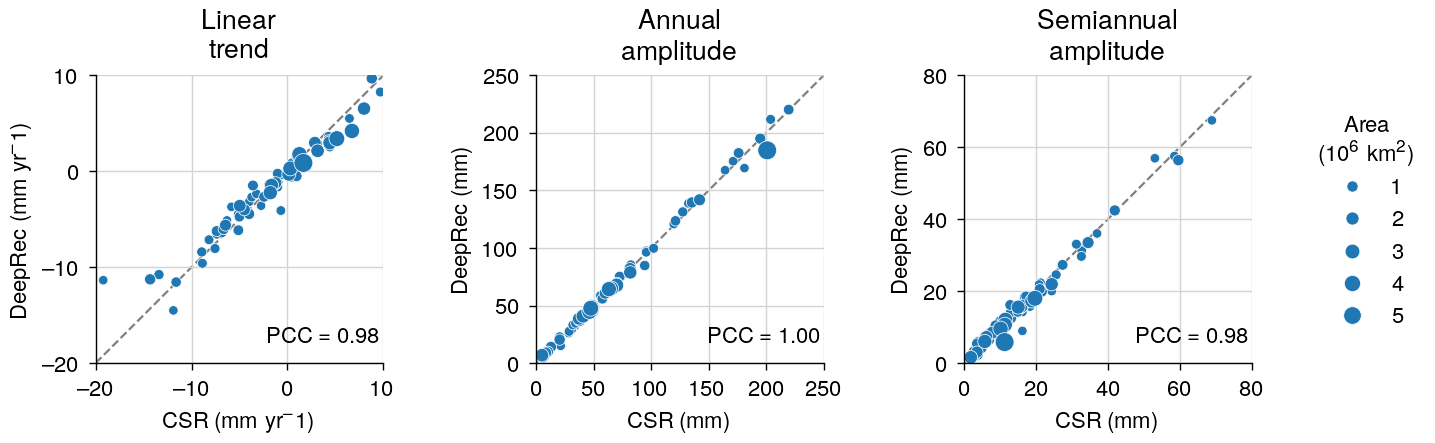

In [22]:
fig, axs = plt.subplots(ncols=3, figsize=(7.2, 2.2))

for i, (ax, (name, df)) in enumerate(zip(axs, df_comps.items())):
    sns.scatterplot(
        df,
        x=target_name,
        y=our_name,
        ax=ax,
        size="area",
        legend=True if i == 0 else False,
    )

    # Unpack dicts
    name_verbose = names_verbose[name]
    unit = units[name]
    lim = lims[name]
    loc = locs[name]
    pcc = pcc_scores[name]

    ax.set(
        title=name_verbose,
        xlabel=f"CSR ({unit})",
        ylabel=f"DeepRec ({unit})",
        xlim=lim,
        ylim=lim,
        aspect="equal",
    )
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

    # Add diagonal line
    ax.plot(
        lim,
        lim,
        color="gray",
        linestyle="dashed",
        linewidth=0.8,
        zorder=0.0,
    )

    # Add score
    ax.text(1.0, 0.07, f"PCC = {pcc:.2f}", ha="right", transform=ax.transAxes)


# Place legend outside of axes
axs[0].legend().remove()
legend = fig.legend(loc="outside right", title="Area\n($10^6$ km$^2$)")
legend.get_title().set_ha("center")

# fig.savefig(FIGURE_DIR / "grace_comp_scatter.pdf", backend="pgf")


## Combine Everything

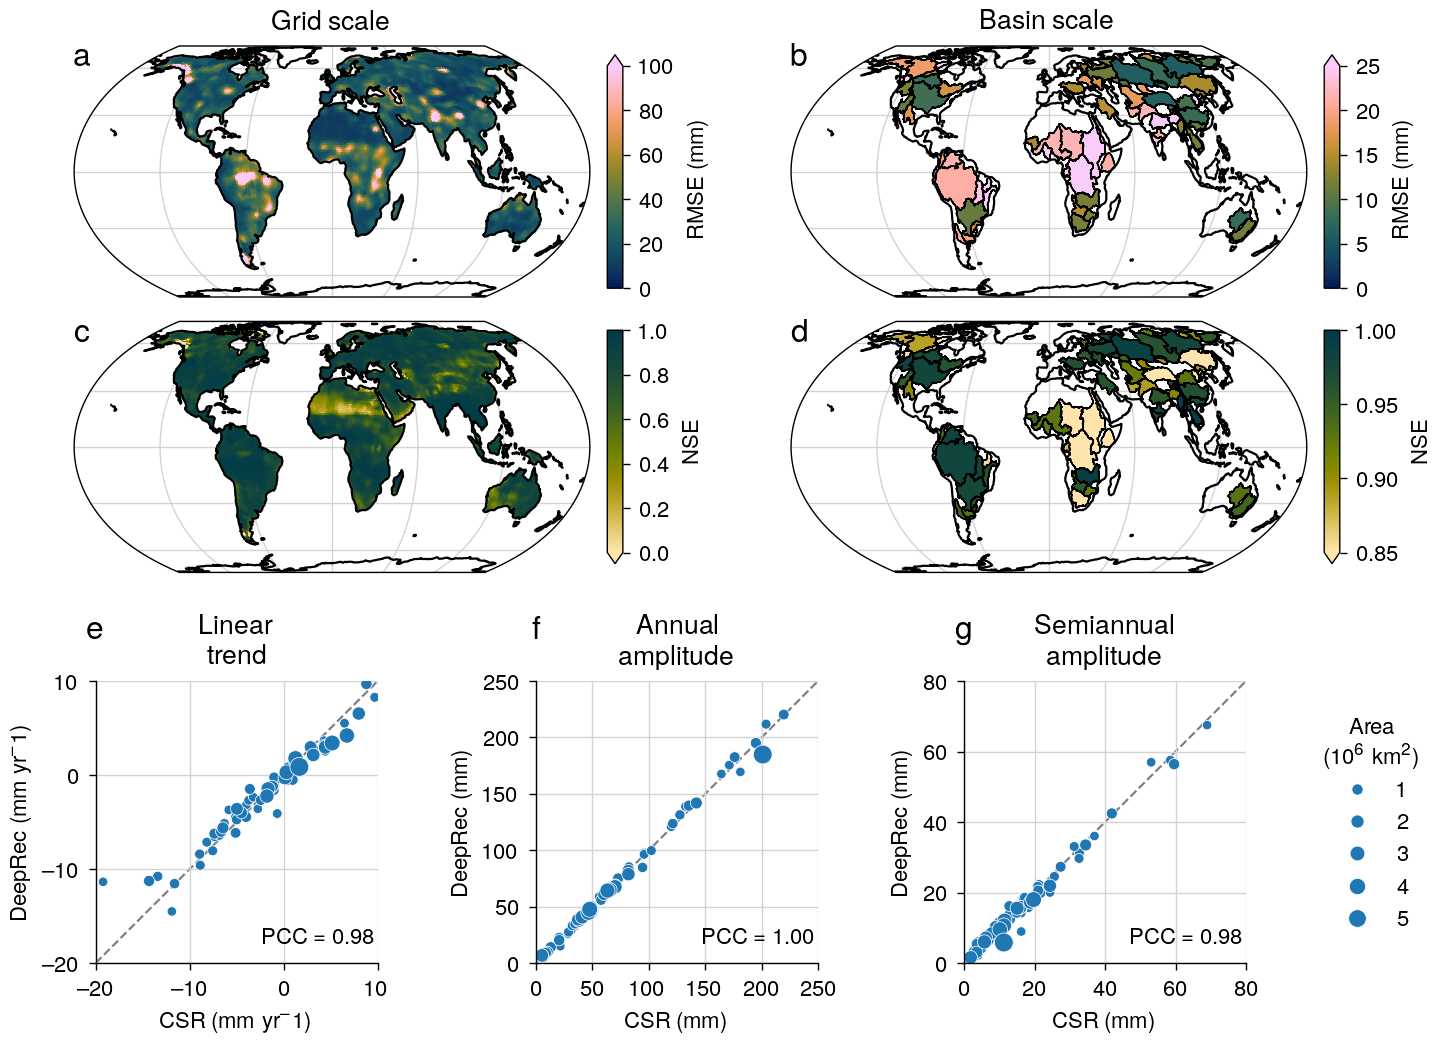

In [23]:
fig = plt.figure(figsize=(7.2, 5.2))
subfigs = fig.subfigures(nrows=2, hspace=0.05, height_ratios=[4, 3])

axs_geo = subfigs[0].subplots(2, 2, subplot_kw={"projection": ccrs.EqualEarth()})
axs_scatter = subfigs[1].subplots(1, 3)

axs_rmse, axs_nse = axs_geo

### MAP PLOTS ###

# Grid scale plots
our_rmse_grid.dr.projplot(vmin=0, vmax=100, ax=axs_rmse[0], **rmse_kwargs)
our_nse_grid.dr.projplot(vmin=0.0, vmax=1.0, ax=axs_nse[0], **nse_kwargs)

# Basin scale plots
our_rmse_basin.dr.projplot_basins(
    our_rmse_grid,
    vmin=0,
    vmax=25,
    ax=axs_rmse[1],
    **rmse_kwargs,
)
our_nse_basin.dr.projplot_basins(
    our_nse_grid,
    vmin=0.85,
    vmax=1.0,
    ax=axs_nse[1],
    **nse_kwargs,
)

# Add basinlines
for ax in [axs_rmse[1], axs_nse[1]]:
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

# Titles
axs_rmse[0].set(title="Grid scale")
axs_rmse[1].set(title="Basin scale")


### SCATTER PLOT ###

for i, (ax, (name, df)) in enumerate(zip(axs_scatter, df_comps.items())):
    sns.scatterplot(
        df,
        x=target_name,
        y=our_name,
        ax=ax,
        size="area",
        legend=True if i == 0 else False,
    )

    # Unpack dicts
    name_verbose = names_verbose[name]
    unit = units[name]
    lim = lims[name]
    loc = locs[name]
    pcc = pcc_scores[name]

    ax.set(
        title=name_verbose,
        xlabel=f"CSR ({unit})",
        ylabel=f"DeepRec ({unit})",
        xlim=lim,
        ylim=lim,
        aspect="equal",
    )
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

    # Add diagonal line
    ax.plot(
        lim,
        lim,
        color="gray",
        linestyle="dashed",
        linewidth=0.8,
        zorder=0,
    )

    # Add PCC score
    ax.text(1.0, 0.07, f"PCC = {pcc:.2f}", ha="right", transform=ax.transAxes)


# Place legend outside of axes
axs_scatter[0].legend().remove()
legend = subfigs[1].legend(loc="outside right", title="Area\n($10^6$ km$^2$)")
legend.get_title().set_ha("center")

# Add letters
for n, ax in enumerate(axs_geo.flat):
    ax.text(
        0.0,
        1.0 - 0.08,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )
for n, ax in enumerate(axs_scatter):
    ax.text(
        0.0,
        1.0 + 0.15,
        string.ascii_lowercase[n + len(axs_geo.flat)],
        ha="center",
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "grace_comp.pdf", backend="pgf")
